## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

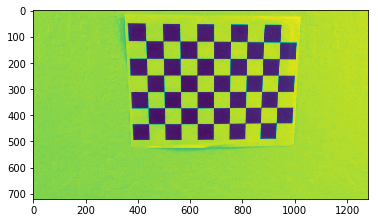

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from numpy import *
from matplotlib.pyplot import *
from scipy.misc import imread


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
    
        
def cal_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undistorted = cal_undistort(gray, objpoints ,imgpoints )
#im = imread(undistorted)
#imshow(im)

plt.imshow(undistorted)

#plt.imshow(gray)




## try on the calibration 

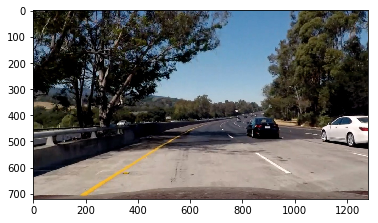

In [7]:
#reading in an image
image = mpimg.imread('../test_images/test5.jpg')
undistorted = cal_undistort(image, objpoints ,imgpoints )
#printing out some stats and plotting
#print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(undistorted)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## colour transfromig 

#### RGB TO LSD 

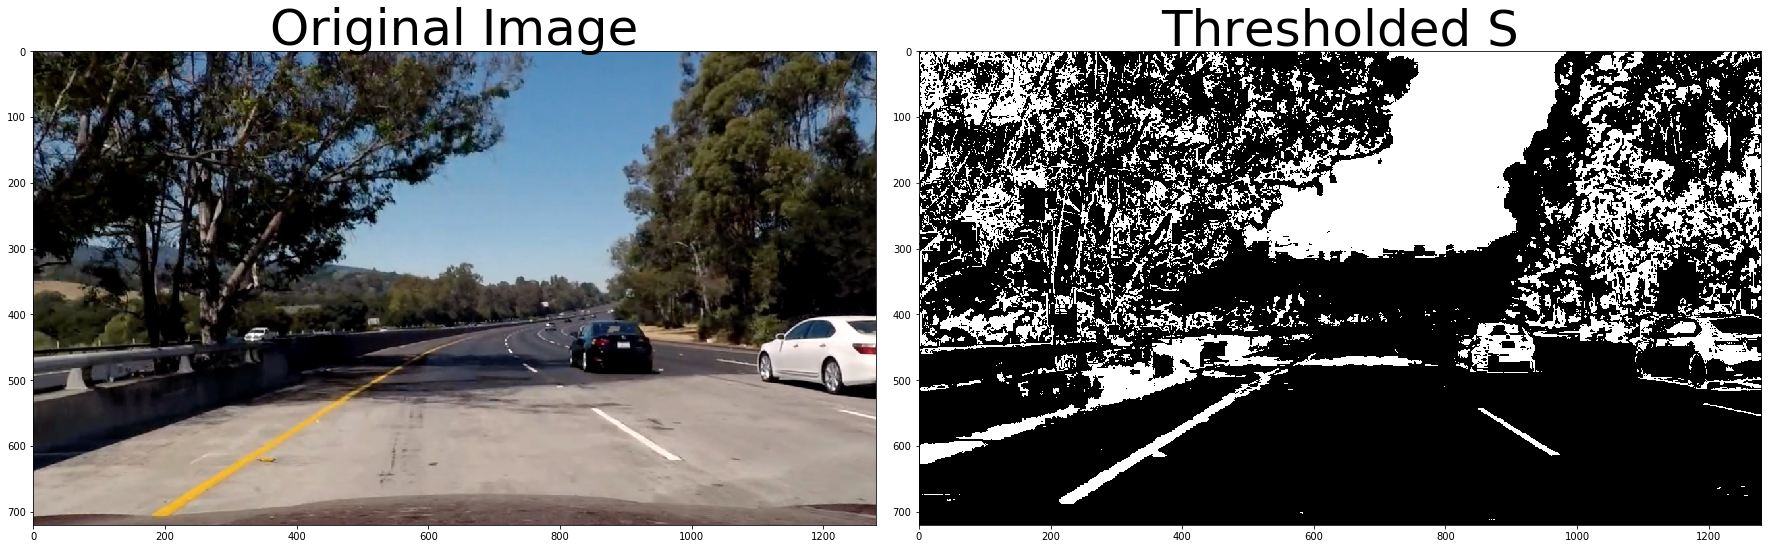

In [8]:

# Read in an image, you can also try test1.jpg or test4.jpg
#image = mpimg.imread('test1.jpg') 

# TODO: Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
     # placeholder line
    return binary
    
# Optional TODO - tune the threshold to try to match the above image!    
hls_binary = hls_select(undistorted, thresh=(0, 270))

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Sober transform

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import math

# Read in an image
#image = mpimg.imread('signs_vehicles_xygrad.png')

# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=7, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Conve  if orient == 'x':
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
        
    abs_sobelr = np.sqrt(abs_sobelx**2 + abs_sobely**2)   
    



    #abs_sobelr = np.absolute(sobelx)


    scaled_sobel = np.uint8(255*abs_sobelr/np.max(abs_sobelr))

    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
   
    # Rescale back to 8 bit integerrt to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) # Remove this line
    return binary_output
    
# Run the function
mag_binary = mag_thresh(hls_binary, sobel_kernel=7, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

error: /tmp/build/80754af9/opencv_1512680315421/work/modules/imgproc/src/color.cpp:11048: error: (-215) scn == 3 || scn == 4 in function cvtColor


#### Mixing the results

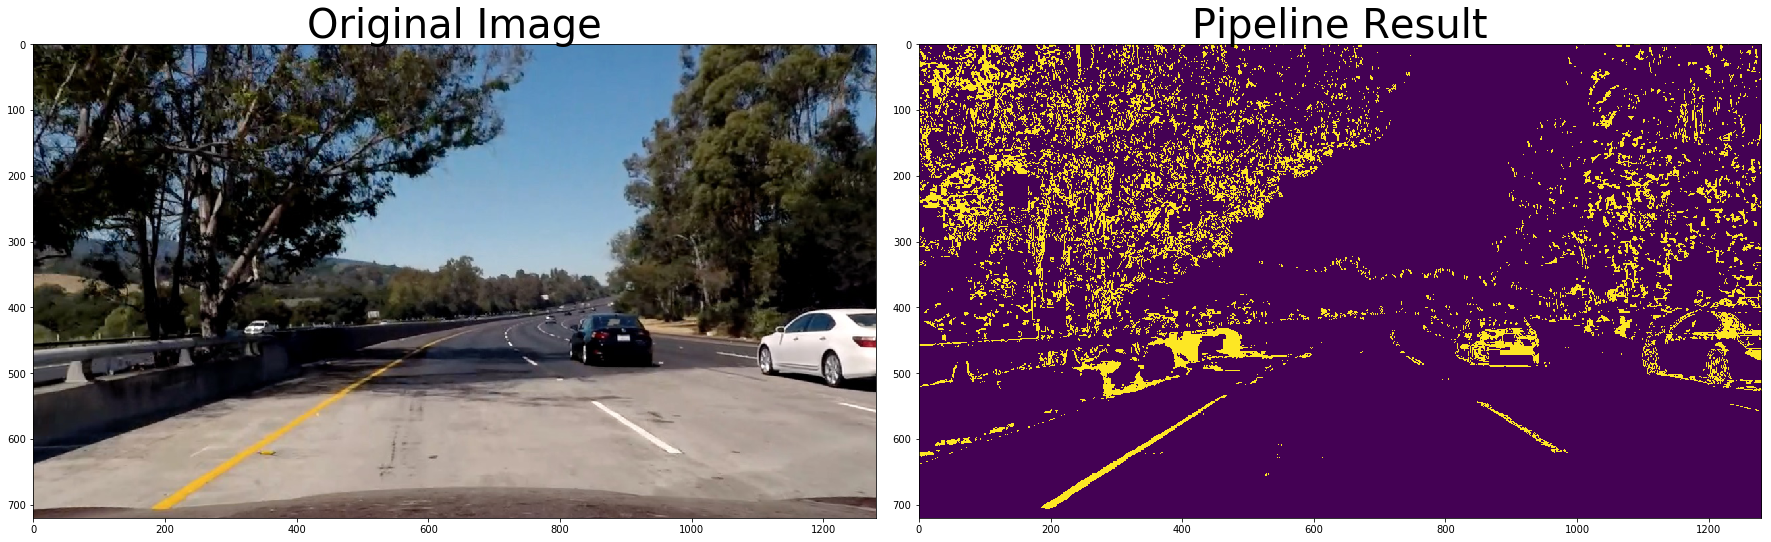

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg




gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def pipeline(img, s_thresh=(180, 265), sx_thresh=(40, 100)):
    
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1 
    # Next we'll create a masked edges image using cv2.fillPoly()
    #mask = np.zeros_like(combined_binary)   
    #ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    #imshape = img.shape
    #vertices = np.array([[(0,imshape[0]),(485, 270), (490, 270), (imshape[1],imshape[0])]], dtype=np.int32)
    #cv2.fillPoly(mask, combined_binary, ignore_mask_color)
    #masked_edges = cv2.bitwise_and(combined_binary, mask)

    return combined_binary
    
result = pipeline(undistorted)
#g = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## perspective transform

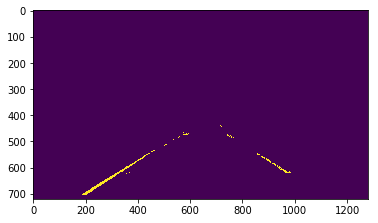

In [11]:
#fisrt we crop the region of intrest
def ver(img):
    imshape = img.shape
    vertices = np.array([[(130,imshape[0]),(635, imshape[0]*0.6), (710, imshape[0]*0.6), (1200,imshape[0])]], dtype=np.int32)
    #vertices = np.array([[130, imshape[0]], 
                # [625, imshape[0]*0.6], 
                   #  [700, imshape[0]*0.6], 
                    # [1200, imshape[0]]], dtype= np.int32)
    return vertices 
ver(result)


def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

im = region_of_interest(result, ver(result))

imshow(im)

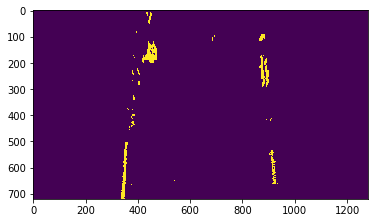

In [12]:
def birdeye(img):
   
    img_size = (img.shape[1] , img.shape[0])
    
    src = np.float32([[560,460],[180,690],[1130,690],[750,460]])

    dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    
    M = cv2.getPerspectiveTransform(src, dst)

    Minv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped , Minv

final1, Minv = birdeye(im)

imshow(final1)





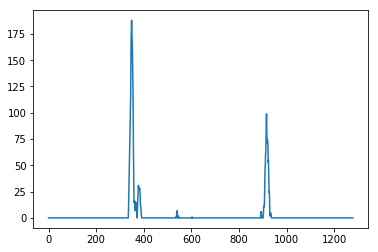

In [13]:
#now we plot the hisotgram to observe
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def hist(img):
    # TO-DO: Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    # TO-DO: Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = hist(final1)
#print(img.shape)
# Visualize the resulting histogram
plt.plot(histogram)

# Lane line detaction 

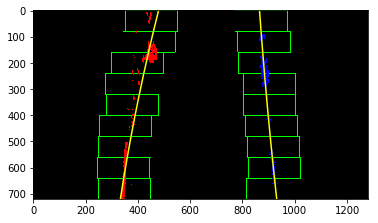

In [14]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image
#binary_warped = mpimg.imread('warped_example.jpg')

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    ym_per_pixel = 30/720 
    xm_per_pixel = 3.7/700 
    
   # left_fit_m = np.polyfit(lefty*ym_per_pixel, leftx*xm_per_pixel, 2)
    #right_fit_m = np.polyfit(righty*ym_per_pixel, rightx*xm_per_pixel, 2)
    
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)

    
    #left_curverad =  ((1 + (2*left_fit[0]*720*ym_per_pixel + left_fit[1])**2)**(3/2))/np.abs(2*left_fit[0])
    #right_curverad =  ((1 + (2*right_fit[0]*720*ym_per_pixel + right_fit[1])**2)**(3/2))/np.abs(2*right_fit[0])
    
    #left_lane = left_fit[0]*(720*ym_per_pixel)**2 + left_fit[1]*720*ym_per_pixel + left_fit[2]
    #right_lane = right_fit[0]*(720*ym_per_pixel)**2 + right_fit[1]*720*ym_per_pixel + right_fit[2]
    
    #radius = np.mean([left_curverad, right_curverad])
    #offset = [640*xm_per_pixel - np.mean([left_lane, right_lane]), right_lane-left_lane]
    
    radius = 1600
    offset = -0.151
    return leftx, lefty, rightx, righty, radius, offset, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, radius, offset, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return ploty, left_fit, right_fit, radius, offset, out_img

ploty, left_fit, right_fit, radius, offset, out_img = fit_polynomial(final1)
plt.imshow(out_img)

In [15]:


"""import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Load our image - this should be a new frame since last time!

# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(final1)

# View your output
plt.imshow(result)"""

"import cv2\nimport numpy as np\nimport matplotlib.image as mpimg\nimport matplotlib.pyplot as plt\n\n# Load our image - this should be a new frame since last time!\n\n# Polynomial fit values from the previous frame\n# Make sure to grab the actual values from the previous step in your project!\nleft_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])\nright_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])\n\ndef fit_poly(img_shape, leftx, lefty, rightx, righty):\n     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###\n    left_fit = np.polyfit(lefty, leftx, 2)\n    right_fit = np.polyfit(righty, rightx, 2)\n    # Generate x and y values for plotting\n    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])\n    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###\n    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]\n    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]\n  

## Mesuaring the curventure

In [16]:
def draw(original_img, img, left_fit, right_fit, Minv):
    """Fill the detected lane
    
    Given an image (np.array), draw a filled polygon of the lane
    
    Parameters:
        original_img (numpy.array): numpy array representation of the original image 
        img (numpy.array): numpy array representation of an image
        left_fit (list): polynomial coefficients of the left lane, highest power first
        right_fit (list): polynomial coefficients of the right lane, highest power first
        Minv (numpy.array): the inverse perspective transform
        
    Returns:
        result: numpy array representation of the lane detected image
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([leftx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_img, 1, newwarp, 0.3, 0)
    return result

def add_calculations(result_img, radius, offset):   
    """Add the radius and offset to an image
    
    Parameters:
        result_img (numpy.array): numpy array representation of an image 
        radius (float): median radius in meters of the left and right lane curvature 
        offset (float) : distance in meters from the center of the lane

    Returns:
        result_img (numpy.array): numpy array representation of an image with added text
    """
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    #cv2.putText(result_img, 'Radius of Curvature: {} m'.format(round(radius)), (50, 100), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    #cv2.putText(result_img, 'Offset: {} m'.format(round(offset[0], 3)), (50, 200), cv2.FONT_HERSHEY_COMPLEX, 1, (255, 255, 255), 4)
    
    return result_img


#ploty, left_fit, right_fit, radius, offset, out_img = fit_polynomial(final1)

# Warp the detected lane boundaries back onto the original image.
#projected_lanes_img = draw(image, final1, left_fit, right_fit, Minv)
    
# Calculate radius and offset
#out_img = add_calculations(projected_lanes_img, radius, offset)

In [17]:

projected_lanes_img = draw(image, final1, left_fit, right_fit, Minv)


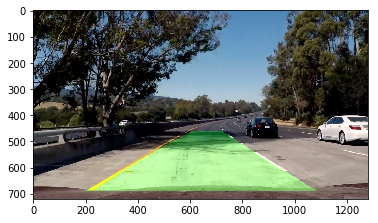

In [18]:
out_img = add_calculations(projected_lanes_img, radius, offset)
imshow(out_img)

## vedio detecation 

In [19]:
# Import everything needed to edit/save/watch video clips
import imageio
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:

import cv2
import glob
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import os
import imageio

#class PipelineVideo(object):
 '''  def __init__(self):
        self.frame_ind = 0
        self.left_fit = None
        self.right_fit = None
        self.radius = None
        self.offset = None
        self.frames = {}
    def update_radius_delta(self, radius):
           if (self.frame_ind == 0) | (self.radius is None):
            return 0
           else:
            return abs((radius-self.radius)/self.radius)
        
    def update_offset_delta(self, offset):
        if (self.frame_ind == 0) | (self.offset is None):
            return 0
        else:
            offset[0]
            return abs((offset[0]-self.offset[0])/self.offset[0]) '''

IndentationError: unexpected indent (<ipython-input-33-5d0420c7f0c4>, line 13)

In [42]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

def image_pipeline(img):
    img_copy = np.copy(img)
    
    # Apply a distortion correction to raw images.
    combined_binary_img  = cv2.undistort(img_copy, mtx, dist, None, mtx)

    # Use color transforms, grdistortion_corrected_imgadients, etc., to create a thresholded binary image.
   # combined_binary_img  = pipeline(distortion_corrected_img)

    
    # Narrow the image to a region of interest
    vertices = np.array([[150, combined_binary_img.shape[0]], 
                         [580, combined_binary_img.shape[0]*0.6], 
                         [745, combined_binary_img.shape[0]*0.6], 
                         [1150, combined_binary_img.shape[0]]], np.int32)
    roi_img = region_of_interest(combined_binary_img, [vertices])

    # Apply a perspective transform to rectify binary image ("birds-eye view").
    #Minv, binary_warped = birdeye(roi_img)
    final1, Minv = birdeye(im)

    # Detect lane pixels and fit to find the lane boundary.
    ploty, left_fit, right_fit, radius, offset, out_img = fit_polynomial(final1)
    
    
    
    # if the changes from the last frame are too great, use the fits from the previous frame
  

    # Warp the detected lane boundaries back onto the original image.
    projected_lanes_img = draw(img_copy, final1, left_fit, right_fit, Minv)

    # Calculate radius and offset
    out_img = add_calculations(projected_lanes_img, radius, offset)
   

    return out_img



[MoviePy] >>>> Building video ./output_video/lane_detection_video.mp4
[MoviePy] Writing video ./output_video/lane_detection_video.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]


IOError: [Errno 32] Broken pipe

MoviePy error: FFMPEG encountered the following error while writing file ./output_video/lane_detection_video.mp4:

 ./output_video/lane_detection_video.mp4: No such file or directory


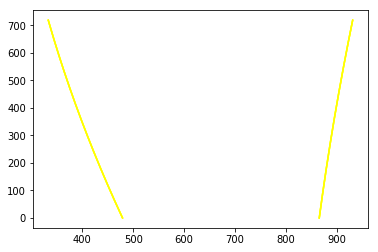

In [46]:
#pipeline = PipelineVideo()
video_out = './output_video/lane_detection_video.mp4'
video_clip = VideoFileClip('../output_video/project_video.mp4')
#clip = video_clip.fl_image(lambda x: image_pipeline(x))
clip = video_clip.fl_image(image_pipeline)
%time clip.write_videofile(video_out, audio=False)